# Panic Project (DHLAB) - Data Analysis

author:  `@cyshin971`  

date:    `2025-06-12`  

version: `1.0`

# 📚 | Import Libraries 

In [1]:
import config as cfg
import logging

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
logging.getLogger('matplotlib').setLevel(logging.WARNING)
# from tqdm.notebook import tqdm
# from joblib import Parallel, delayed

from library.pandas_utils import move_column, remove_columns, aggregate_by_column, create_empty_df, find_unique_row
from library.text_utils import save_as_csv
from library.json_utils import save_dict_to_file
# from library.path_utils import get_file_path

# 📁 | Path Variables 

In [2]:
DATA_PATH = "../_data"
TMP_PATH = "./cys/_tmp"
OUTPUT_PATH = "./cys/_output"

# ⛏️ | Scraped Data

load preprocessed data (by `junyeol_lee`)
- Each entry are the datapoints for a patient (`ID`) on a specific date (`date`)
- If there were multiple datapoints for a specific date (`date`) for a specific patient (`ID`), the values were processed (`sum`, `avg`, etc.) to a representation for the day

## Scraped Data Features

In [3]:
metadata_filename = "final_result_20250612"

features_dict = {
    "scraped_data_filename": metadata_filename,
	"demography": [
		'gender', 'age', 'marriage', 'job', 'smkHx', 'drinkHx', 'suicideHx'
	],
	"dailylog": [
		'panic', 'severity', 'exercise', 'alcohol', 'coffee', 'menstruation',
		'smoking', 'positive_feeling', 'negative_feeling', 'positive_E', 'negative_E',
		'anxiety', 'annoying'
	],
	"lifelog": [
		'HR_var', 'HR_max', 'HR_mean', 'HR_hvar_mean', 'HR_acrophase', 'HR_amplitude',
		'HR_mesor','HR_acrophase_difference', 'HR_acrophase_difference_2d', 'HR_amplitude_difference',
		'HR_amplitude_difference_2d', 'HR_mesor_difference', 'HR_mesor_difference_2d',
		'bandpower(0.001-0.0005Hz)', 'bandpower(0.0005-0.0001Hz)', 'bandpower(0.0001-0.00005Hz)', 'bandpower(0.00005-0.00001Hz)',
		'steps', 'SLT1', 'SLT2', 'SLT3', 'SLT4', 'SLT5', 'SLT6', 'total_sleep'
	],
	"questionnaire": [
		'PHQ_9', 'STAI_X2', 'CSM', 'CTQ_1', 'CTQ_2', 'CTQ_3', 'CTQ_4', 'CTQ_5', 'KRQ', 'MDQ',
		'ACQ', 'APPQ_1', 'APPQ_2', 'APPQ_3', 'BSQ', 'GAD_7', 'BRIAN'
	],
    "id": [
        'ID', 'date'
    ],
    "label": [
        'severity'
    ],
    "metadata": []
}

demo_vars = features_dict["demography"]
dailylog_vars = features_dict["dailylog"]
lifelog_vars = features_dict["lifelog"]
questionnaire_vars = features_dict["questionnaire"]

state_vars = demo_vars
trait_vars = dailylog_vars + lifelog_vars + questionnaire_vars
all_vars = state_vars + dailylog_vars + lifelog_vars + questionnaire_vars

print(f'Number of variables: {len(all_vars)}')
print(f'   Demographic variables: {len(state_vars)}')
print(f'   Daily log variables: {len(dailylog_vars)}')
print(f'   Life log variables: {len(lifelog_vars)}')
print(f'   Questionnaire variables: {len(questionnaire_vars)}')

# _ = save_dict_to_file(features_dict, TMP_PATH, "scraped_features")

Number of variables: 62
   Demographic variables: 7
   Daily log variables: 13
   Life log variables: 25
   Questionnaire variables: 17


## Load Scraped Data

In [4]:
scraped_data = pd.read_csv(os.path.join(DATA_PATH, f"{metadata_filename}.csv"))

# check if all columns are present
missing_cols = [col for col in all_vars if col not in scraped_data.columns]
if missing_cols:
    logging.warning(f"Missing columns in scraped_data: {missing_cols}")
else:
	logging.info("All expected columns are present in scraped_data.")
# convert date column to datetime format
scraped_data['date'] = pd.to_datetime(scraped_data['date'], format='%Y-%m-%d')
remove_columns(scraped_data, ['Unnamed: 0'])

print(f"Number of rows: {scraped_data.shape[0]}")
print(f"Number of columns: {scraped_data.shape[1]}")
display(scraped_data.head(5))

INFO - (1965066665.py) <module>: All expected columns are present in scraped_data.


Number of rows: 24370
Number of columns: 85


,ID,date,panic,gender,marriage,job,smkHx,drinkHx,suicideHx,suicide_need,...,STAI_X1,SLT1,SLT2,SLT3,SLT4,SLT5,SLT6,total_sleep,smoking,menstruation
0,SYM1-1-100,2021-03-02,2.0,1,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,SYM1-1-100,2021-03-03,2.0,1,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,SYM1-1-100,2021-03-19,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,0.0,8.0,0.0,0.00,0.00,0.00,8.00,NaN,NaN
3,SYM1-1-100,2021-08-12,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,0.9,0.0,0.0,3.68,1.23,1.52,7.33,NaN,NaN
4,SYM1-1-102,NaT,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# ⚒️ | Data Preprocessing

Changes from scraped data:
- add `entry_id` to identify each entry: `'ID'_'date'`
- add `dataset` to identify source: `SYM1`, `SYM2`, `PXPN`
- convert `panic` (`0`, `1`, `2` = panic) to days befor panic (`dbp`) (panic = `0`, `1`, `2`)
- add `panic_label` : whether a panic occurred in the entry (`boolean`)
- demographic features were removed from preprocessed data (`data_pre`)
- the data was filtered to remove entries with only demgraphic data

TODO:
Coffe: patient별 평균 / 없는 사람은 0으로
Smoking: patient별 entry 행수 기준 50% 이상인 경우는 평균으로 넣고 아닌 경우 결측 0으로 하기
Total_sleep: patient별 평균 (가장 쉽게)

## Initialize Preprocessed Data

- add `entry_id` to identify each entry: `'ID'_'date'`
- add `dataset` to identify source: `SYM1`, `SYM2`, `PXPN`
- convert `panic` (`0`, `1`, `2` = panic) to days befor panic (`dbp`) (panic = `0`, `1`, `2`)
- add `panic_label` (boolean)

In [5]:
data_pre_init = create_empty_df()
data_pre_init = scraped_data.copy()

# Add 'entry_id' column: unique identifier for each row
data_pre_init['entry_id'] = data_pre_init['ID'] + '_' + data_pre_init['date'].astype(str)
instance_id_unique = data_pre_init['entry_id'].unique()
move_column(data_pre_init, 'entry_id', 0)
print("Number of unique entry IDs:", len(instance_id_unique))
# Check if 'entry_id' is unique
if data_pre_init['entry_id'].duplicated().any():
	# return the rows with duplicate 'entry_id'
	duplicates = data_pre_init[data_pre_init['entry_id'].duplicated(keep=False)]
	display(duplicates.head(5))
	save_as_csv(duplicates, TMP_PATH, f"duplicates_{metadata_filename}")
	raise ValueError("Duplicate 'entry_id' found in the data. Please resolve this issue before proceeding.")

# Add 'dataset' column: source of data
data_pre_init['dataset'] = data_pre_init['ID'].str.split('_').str[0]
data_pre_init['dataset'] = data_pre_init['dataset'].str.split('-').str[0]
move_column(data_pre_init, 'dataset', 1)

# Convert 'panic' column to Days Before Panic (dbp)
data_pre_init['dbp'] = data_pre_init.apply(
	lambda row: np.nan if row['panic'] == 0
 				else 0 if row['panic'] == 2 else row['panic'],
	axis=1
)
remove_columns(data_pre_init, ['panic'])

# Add panic_label column
data_pre_init['panic_label'] = data_pre_init['dbp'].apply(lambda x: 1 if x == 0 else 0)

# Convert 'daily_log' variables = 0 to NaN
# NOTE: junyeol_lee changed to show quantity for each and kept NaN for no entries instead of 0 (20250612)
# data_pre_init['exercise'] = data_pre_init['exercise'].replace(0, np.nan)
# data_pre_init['alcohol'] = data_pre_init['alcohol'].replace(0, np.nan)
# data_pre_init['coffee'] = data_pre_init['coffee'].replace(0, np.nan)
# data_pre_init['menstruation'] = data_pre_init['menstruation'].replace(0, np.nan)
# data_pre_init['smoking'] = data_pre_init['smoking'].replace(0, np.nan)

# Update the features_dict
features_dict['id'] = ['entry_id'] + features_dict['id'] + ['dataset']
features_dict['label'] = ['dbp', 'panic_label'] + features_dict['label']
features_dict['dailylog'].remove('panic')

Number of unique entry IDs: 24370


In [6]:
display(data_pre_init.head(5))
print("Unique sources in metadata_ljy: ", data_pre_init['dataset'].unique())
print("Number of entries in metadata_ljy:", data_pre_init.shape[0])
sym1_n = data_pre_init[data_pre_init['dataset'] == 'SYM1'].shape[0]
sym2_n = data_pre_init[data_pre_init['dataset'] == 'SYM2'].shape[0]
print("    SYM entries:", sym1_n+sym2_n)
print("    PXPN entries:", data_pre_init[data_pre_init['dataset'] == 'PXPN'].shape[0])
print("Number of unique IDs in metadata_ljy:", len(data_pre_init['ID'].unique()))
# find the unique IDs for SYM1 and SYM2
sym1_ids = data_pre_init[data_pre_init['dataset'] == 'SYM1']['ID'].unique()
sym2_ids = data_pre_init[data_pre_init['dataset'] == 'SYM2']['ID'].unique()
print("    SYM IDs: ", len(sym1_ids)+len(sym2_ids))
print("    PXPN IDs: ", len(data_pre_init[data_pre_init['dataset'] == 'PXPN']['ID'].unique()))
print("Number of panic events (dbp=0):", data_pre_init[data_pre_init['dbp'] == 0].shape[0])

,entry_id,dataset,ID,date,gender,marriage,job,smkHx,drinkHx,suicideHx,...,SLT2,SLT3,SLT4,SLT5,SLT6,total_sleep,smoking,menstruation,dbp,panic_label
0,SYM1-1-100_2021-03-02,SYM1,SYM1-1-100,2021-03-02,1,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1
1,SYM1-1-100_2021-03-03,SYM1,SYM1-1-100,2021-03-03,1,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1
2,SYM1-1-100_2021-03-19,SYM1,SYM1-1-100,2021-03-19,1,0.0,0.0,0.0,0.0,0.0,...,8.0,0.0,0.00,0.00,0.00,8.00,NaN,NaN,NaN,0
3,SYM1-1-100_2021-08-12,SYM1,SYM1-1-100,2021-08-12,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.68,1.23,1.52,7.33,NaN,NaN,NaN,0
4,SYM1-1-102_NaT,SYM1,SYM1-1-102,NaT,0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


Unique sources in metadata_ljy:  ['SYM1' 'SYM2' 'PXPN']
Number of entries in metadata_ljy: 24370
    SYM entries: 23531
    PXPN entries: 839
Number of unique IDs in metadata_ljy: 429
    SYM IDs:  400
    PXPN IDs:  29
Number of panic events (dbp=0): 802


## Initialize Metadata

initialize `metadata` by adding
- `demography_data` : whether demography data exists in the entry (`boolean`)
- `dailylog_data`, `lifelog_data`, `questionnaire_data` : whether each data group exists in the entry (`boolean`)
- `dtype_n` : how many of the 3 `state` groups exists in the entry (`int`)

In [7]:
metadata_init = create_empty_df()
metadata_init = data_pre_init.copy()

metadata_init['demography_data'] = metadata_init[features_dict['demography']].notnull().any(axis=1).astype(int)
metadata_init['dailylog_data'] = metadata_init[features_dict['dailylog']].notnull().any(axis=1).astype(int)
metadata_init['lifelog_data'] = metadata_init[features_dict['lifelog']].notnull().any(axis=1).astype(int)
metadata_init['questionnaire_data'] = metadata_init[features_dict['questionnaire']].notnull().any(axis=1).astype(int)
metadata_init['dtype_n'] = metadata_init['dailylog_data'] + metadata_init['lifelog_data'] + metadata_init['questionnaire_data']
move_column(metadata_init, 'dtype_n', 8)

add_list = ['dailylog_data', 'lifelog_data', 'questionnaire_data', 'dtype_n']
for item in add_list:
	if item not in features_dict['metadata']:
		features_dict['metadata'].append(item)
del add_list

check_metadata = False
if check_metadata:
    check_type = 'dailylog' # demography, dailylog, lifelog, questionnaire
    check_for = 1
    test = metadata_init[metadata_init[check_type+'_data'] == check_for].copy()
    test = test[features_dict['id']+features_dict['metadata']+features_dict[check_type]]
    print(f"--------- TEST {test.shape[0]} ENTRIES WITH {check_type} = {check_for} ---------")
    display(test.head(10))
    save_as_csv(test, TMP_PATH, f"metadata_{check_type}_{check_for}")
    print("------------------------------------------------------------------------")
    del test, check_type, check_for

display(metadata_init.head(5))

,entry_id,dataset,ID,date,gender,marriage,job,smkHx,dtype_n,drinkHx,...,SLT6,total_sleep,smoking,menstruation,dbp,panic_label,demography_data,dailylog_data,lifelog_data,questionnaire_data
0,SYM1-1-100_2021-03-02,SYM1,SYM1-1-100,2021-03-02,1,0.0,0.0,0.0,2,0.0,...,NaN,NaN,NaN,NaN,0.0,1,1,1,0,1
1,SYM1-1-100_2021-03-03,SYM1,SYM1-1-100,2021-03-03,1,0.0,0.0,0.0,2,0.0,...,NaN,NaN,NaN,NaN,0.0,1,1,1,0,1
2,SYM1-1-100_2021-03-19,SYM1,SYM1-1-100,2021-03-19,1,0.0,0.0,0.0,2,0.0,...,0.00,8.00,NaN,NaN,NaN,0,1,0,1,1
3,SYM1-1-100_2021-08-12,SYM1,SYM1-1-100,2021-08-12,1,0.0,0.0,0.0,2,0.0,...,1.52,7.33,NaN,NaN,NaN,0,1,0,1,1
4,SYM1-1-102_NaT,SYM1,SYM1-1-102,NaT,0,0.0,0.0,0.0,0,0.0,...,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0


## Extract Demography Data

- All patients within the scraped data were confirmed to have demographic data (`demography_data` = `True`)
- as such demography_data will not be included in the `metadata`
- Demography data was extracted and saved as `demography.csv` to the `output` directory

In [8]:
agg_matrix = [
	('gender_n', 'gender', 'nunique'),
	('age_n', 'age', 'nunique'),
	('marriage_n', 'marriage', 'nunique'),
	('job_n', 'job', 'nunique'),
	('smkHx_n', 'smkHx', 'nunique'),
	('drinkHx_n', 'drinkHx', 'nunique'),
	('suicideHx_n', 'suicideHx', 'nunique'),
    ('gender', 'gender', 'first'),
	('age', 'age', 'first'),
	('marriage', 'marriage', 'first'),
	('job', 'job', 'first'),
	('smkHx', 'smkHx', 'first'),
	('drinkHx', 'drinkHx', 'first'),
	('suicideHx', 'suicideHx', 'first')
]
demo_data = create_empty_df()
demo_data = aggregate_by_column(metadata_init, 'ID', agg_matrix)
# check if the length of each unique value is 1
non_unique_cols = []
for col in features_dict['demography']:
	if demo_data[col+'_n'].apply(lambda x: x > 1).any():
		non_unique_cols.append(col)
if non_unique_cols:
	raise ValueError(f"Demographic columns {non_unique_cols} are not unique for each ID in demo_data.")
else:
	print("All demographic columns are unique for each ID in demo_data.")

for col in features_dict['demography']:
	remove_columns(demo_data, [col+'_n'])
print(f"Number of rows in demo_data: {demo_data.shape[0]}")
display(demo_data.head(5))

save_as_csv(demo_data, OUTPUT_PATH, f"panic_demography_data({metadata_filename})")

All demographic columns are unique for each ID in demo_data.
Number of rows in demo_data: 429


,ID,gender,age,marriage,job,smkHx,drinkHx,suicideHx
0,PXPN_10006,0,32.0,0.0,1.0,1.0,1.0,0.0
1,PXPN_10007,1,38.0,1.0,1.0,0.0,0.0,0.0
2,PXPN_10008,0,38.0,1.0,0.0,0.0,1.0,0.0
3,PXPN_10009,1,28.0,0.0,0.0,1.0,0.0,1.0
4,PXPN_10010,1,21.0,0.0,0.0,1.0,1.0,0.0


DEBUG - (text_utils.py) save_as_csv: Saved panic_demography_data(final_result_20250612).csv to C:\Users\cyshi\OneDrive\Documents\GitHub\Panic-Project-CYS\cys\_output


WindowsPath('C:/Users/cyshi/OneDrive/Documents/GitHub/Panic-Project-CYS/cys/_output/panic_demography_data(final_result_20250612).csv')

## Construct Intermediate Metadata
- the current `metadata` (`metadata_init`) was filtered to include only columns for identification, added columns for metadata, and labels
- the `metadata` was also filtered to get rid of all entries that only have demography data (`dtype_n` = 0)

In [9]:
metadata_int = create_empty_df()
metadata_int = metadata_init.copy()

metadata_int = metadata_int[features_dict['id'] + features_dict['metadata'] + features_dict['label']]
move_column(metadata_int, 'severity', -1)
metadata_int = metadata_int[metadata_int['dtype_n'] > 0]
display(metadata_int.head(5))

,entry_id,ID,date,dataset,dailylog_data,lifelog_data,questionnaire_data,dtype_n,dbp,panic_label,severity
0,SYM1-1-100_2021-03-02,SYM1-1-100,2021-03-02,SYM1,1,0,1,2,0.0,1,4.0
1,SYM1-1-100_2021-03-03,SYM1-1-100,2021-03-03,SYM1,1,0,1,2,0.0,1,4.0
2,SYM1-1-100_2021-03-19,SYM1-1-100,2021-03-19,SYM1,0,1,1,2,NaN,0,NaN
3,SYM1-1-100_2021-08-12,SYM1-1-100,2021-08-12,SYM1,0,1,1,2,NaN,0,NaN
5,SYM1-1-103_2021-02-16,SYM1-1-103,2021-02-16,SYM1,0,1,0,1,NaN,0,NaN


## Filter Preprocessed Data

- demographic features were removed from preprocessed data (`data_pre`)
- the data was filtered to remove entries with only demgraphic data
- the removed IDs were checked to see if no relevant entries were discarded

In [10]:
data_pre = create_empty_df()
data_pre = data_pre_init.copy()
# Remove demographic features from data_proc
remove_columns(data_pre, features_dict['demography'])
# Filter data_proc to keep only rows with entry IDs present in metadata_int
metadata_int_unique_ids = metadata_int['entry_id'].unique()
data_pre = data_pre[data_pre['entry_id'].isin(metadata_int_unique_ids)]

# remove rows with null dates
data_pre = data_pre[data_pre['date'].notnull()]

# Find IDs present in unfiltered_data but missing in filtered_data (i.e., lost after filtering)
check_missing_ids = False
if check_missing_ids:
	missing_ids = np.setdiff1d(data_pre_init['ID'].unique(), data_pre['ID'].unique())
	missing_data = data_pre_init[data_pre_init['ID'].isin(missing_ids)]
	print(f"Number of IDs lost after filtering: {len(missing_ids)}")
	_ = save_as_csv(missing_data, TMP_PATH, f"missing_{metadata_filename}")

## 💾 | Save Preprocessed Data

In [11]:
# save data_pre to CSV
save_as_csv(data_pre, OUTPUT_PATH, f"panic_pre_data({metadata_filename})")

display(data_pre.head(3))
print("--------------------------------------------------------")
print("Total entries in original: ", data_pre_init.shape[0])
sym1_n = data_pre_init[data_pre_init['dataset'] == 'SYM1'].shape[0]
sym2_n = data_pre_init[data_pre_init['dataset'] == 'SYM2'].shape[0]
print("    SYM entries:", sym1_n+sym2_n)
print("    PXPN entries:", data_pre_init[data_pre_init['dataset'] == 'PXPN'].shape[0])
print("Number of unique IDs in original:", len(data_pre_init['ID'].unique()))
# find the unique IDs for SYM1 and SYM2
sym1_ids = data_pre_init[data_pre_init['dataset'] == 'SYM1']['ID'].unique()
sym2_ids = data_pre_init[data_pre_init['dataset'] == 'SYM2']['ID'].unique()
print("    SYM IDs: ", len(sym1_ids)+len(sym2_ids))
print("    PXPN IDs: ", len(data_pre_init[data_pre_init['dataset'] == 'PXPN']['ID'].unique()))
print("Number of panic events (dbp=0):", data_pre_init[data_pre_init['dbp'] == 0].shape[0])
print("--------------------------------------------------------")
print("Total entries in filtered: ", data_pre.shape[0])
sym1_n = data_pre[data_pre['dataset'] == 'SYM1'].shape[0]
sym2_n = data_pre[data_pre['dataset'] == 'SYM2'].shape[0]
print("    SYM entries:", sym1_n+sym2_n)
print("    PXPN entries:", data_pre[data_pre['dataset'] == 'PXPN'].shape[0])
print("Number of unique IDs in filtered:", len(data_pre['ID'].unique()))
# find the unique IDs for SYM1 and SYM2
sym1_ids = data_pre[data_pre['dataset'] == 'SYM1']['ID'].unique()
sym2_ids = data_pre[data_pre['dataset'] == 'SYM2']['ID'].unique()
print("    SYM IDs: ", len(sym1_ids)+len(sym2_ids))
print("    PXPN IDs: ", len(data_pre[data_pre['dataset'] == 'PXPN']['ID'].unique()))
print("Number of panic events (dbp=0):", data_pre[data_pre['dbp'] == 0].shape[0])

DEBUG - (text_utils.py) save_as_csv: Saved panic_pre_data(final_result_20250612).csv to C:\Users\cyshi\OneDrive\Documents\GitHub\Panic-Project-CYS\cys\_output


,entry_id,dataset,ID,date,suicide_need,medication_in_month,alcohol,bandpower(0.001-0.0005Hz),bandpower(0.0005-0.0001Hz),bandpower(0.0001-0.00005Hz),...,SLT2,SLT3,SLT4,SLT5,SLT6,total_sleep,smoking,menstruation,dbp,panic_label
0,SYM1-1-100_2021-03-02,SYM1,SYM1-1-100,2021-03-02,0.0,0.0,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1
1,SYM1-1-100_2021-03-03,SYM1,SYM1-1-100,2021-03-03,0.0,0.0,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1
2,SYM1-1-100_2021-03-19,SYM1,SYM1-1-100,2021-03-19,0.0,0.0,NaN,NaN,NaN,NaN,...,8.0,0.0,0.0,0.0,0.0,8.0,NaN,NaN,NaN,0


--------------------------------------------------------
Total entries in original:  24370
    SYM entries: 23531
    PXPN entries: 839
Number of unique IDs in original: 429
    SYM IDs:  400
    PXPN IDs:  29
Number of panic events (dbp=0): 802
--------------------------------------------------------
Total entries in filtered:  24096
    SYM entries: 23282
    PXPN entries: 814
Number of unique IDs in filtered: 274
    SYM IDs:  245
    PXPN IDs:  29
Number of panic events (dbp=0): 802


# 📖 | Metadata

**Description**
- `entry_id`: ID for each entry `'ID'_'date'`
- `ID`: ID for each patient
- `date`: logging date of each entry
- `dataset`: source of entry (`SYM1`, `SYM2`, `PXPN`)
- `dailylog_data`: whether daily log data exists in the entry (`boolean`)
- `lifelog_data`: whether life log data exists in the entry (`boolean`)
- `questionnaire_data`: whether questionnaire data exists in the entry (`boolean`)
- `dtype_n`: how many of the 3 `state` groups exists in the entry (`int`)
- `dbp`: number of consecutive days prior to panic. i.e. panic day = 0; 1 day prior = 1; etc. (up to 3)
- `n_prior_data`: number of existing consecutive prior (days) entries
- `ref_event_id`: the `entry_id` to which days before panic (`dbp`) is referencing
- `valid_entry_3`: whether the entry has 3 consecutive days of prior data (`n_prior_data`)
- `valid_entry_2`: whether the entry has 2 consecutive days of prior data (`n_prior_data`)
- `valid_entry_1`: whether the entry has 1 consecutive days of prior data (`n_prior_data`)
- `panic_label`: whether a panic occured in the entry (`boolean`)
- `severity`: severity of the panic (1 ~ 5)

## Calculate Days Before Panic (``dbp``) and Prior Consecutive Days (``n_prior_data``)

- calculate the consecutive 'days before panic' (`dbp`):
  - day when panic occured -> `dbp` = 0
  - 1 day before panic -> `dbp` = 1
  - 2 day before panic -> `dbp` = 2
  - 3 day before panic -> `dbp` = 3 (etc)
  - stop calculating at a set limit (`delta_days`) or if a panic occurred within the limit
- calculate the number of existing prior consecutive (days) entries (`n_prior_data`) (Default: 3)
  - stop calculating at a certain limit (`lookback_limit`) (Default: 7)

> May take ~ 1min

In [12]:
metadata_calc = create_empty_df()
metadata_calc = metadata_int.copy()

metadata_calc['n_prior_data']    = None
metadata_calc['ref_event_id']    = None
move_column(metadata_calc, 'panic_label', -1)
move_column(metadata_calc, 'severity', -1)
metadata_calc.sort_values(by=['ID', 'date'], ascending=False, inplace=True)

d_days = 3
l_back_lim = 7

def calculate_days_before_panic(df, patient_id, delta_days=3, lookback_limit=7):
    patient_data = df[df['ID'] == patient_id]
    entry_dates_series = patient_data['date']
    if len(set(entry_dates_series)) != len(entry_dates_series):
        raise ValueError(f"Duplicate dates found for patient {patient_id}. Please check the data.")
    panic_dates_series = patient_data[patient_data['dbp'] == 0]['date']
    if len(set(panic_dates_series)) != len(panic_dates_series):
        raise ValueError(f"Duplicate panic dates found for patient {patient_id}. Please check the data.")
    
    entry_dates = set(entry_dates_series)
    panic_dates = set(panic_dates_series)

    for panic_date in sorted(panic_dates, reverse=True): # Sort from latest to earliest
        for j in range(1, delta_days + 1):
            prior_date = panic_date - pd.Timedelta(days=j)
            if prior_date in entry_dates:
                index = patient_data[patient_data['date'] == prior_date].index[0]
                df.loc[index, 'dbp'] = j
                df.loc[index, 'ref_event_id'] = patient_data.loc[index, 'entry_id']
    
    for entry_date in sorted(entry_dates, reverse=True):
        for j in range(1, lookback_limit + 1):
            if j == lookback_limit:
                df.loc[index, 'n_prior_data'] = j
                break
            prior_date = entry_date - pd.Timedelta(days=j)
            if prior_date not in entry_dates:
                break
            index = patient_data[patient_data['date'] == prior_date].index[0]
            if df.loc[index, 'panic_label'] == 1:
                break
            index = patient_data[patient_data['date'] == entry_date].index[0]
            df.loc[index, 'n_prior_data'] = j

def process_calculate_days_before_panic(df, delta_days=3, lookback_limit=7):
    patient_ids = df['ID'].unique()
    for patient_id in patient_ids:
        calculate_days_before_panic(df, patient_id, delta_days, lookback_limit)
        progress = (np.where(patient_ids == patient_id)[0][0] + 1) / len(patient_ids) * 100
        print(f"Processing: {progress:.2f}% complete", end='\r')
    # replace None values in 'n_prior_data' with 0
    df['n_prior_data'] = df['n_prior_data'].fillna(0).astype(int)
    return df

metadata_int = process_calculate_days_before_panic(metadata_calc, delta_days=d_days, lookback_limit=l_back_lim)

# update features_dict with metadata columns
features_dict['metadata'] = metadata_int.columns.tolist()

C:\Users\cyshi\AppData\Local\Temp\ipykernel_37540\2664888677.py:54: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['n_prior_data'] = df['n_prior_data'].fillna(0).astype(int)


In [13]:
p_id = 'PXPN_10006'
disp_df = metadata_int[metadata_int['ID'] == p_id]
display(disp_df.head(10))
del disp_df, p_id

,entry_id,ID,date,dataset,dailylog_data,lifelog_data,questionnaire_data,dtype_n,dbp,n_prior_data,ref_event_id,panic_label,severity
23559,PXPN_10006_2024-12-02,PXPN_10006,2024-12-02,PXPN,0,1,1,2,NaN,1,None,0,NaN
23558,PXPN_10006_2024-12-01,PXPN_10006,2024-12-01,PXPN,1,1,1,3,NaN,0,None,0,NaN
23557,PXPN_10006_2024-11-30,PXPN_10006,2024-11-30,PXPN,1,1,1,3,0.0,7,None,1,1.0
23556,PXPN_10006_2024-11-29,PXPN_10006,2024-11-29,PXPN,0,1,1,2,1.0,7,PXPN_10006_2024-11-29,0,NaN
23555,PXPN_10006_2024-11-28,PXPN_10006,2024-11-28,PXPN,1,1,1,3,2.0,7,PXPN_10006_2024-11-28,0,NaN
23554,PXPN_10006_2024-11-27,PXPN_10006,2024-11-27,PXPN,1,1,1,3,3.0,7,PXPN_10006_2024-11-27,0,NaN
23553,PXPN_10006_2024-11-26,PXPN_10006,2024-11-26,PXPN,1,1,1,3,NaN,7,None,0,NaN
23552,PXPN_10006_2024-11-25,PXPN_10006,2024-11-25,PXPN,1,1,1,3,NaN,7,None,0,NaN
23551,PXPN_10006_2024-11-24,PXPN_10006,2024-11-24,PXPN,1,1,1,3,NaN,7,None,0,NaN
23550,PXPN_10006_2024-11-23,PXPN_10006,2024-11-23,PXPN,1,1,1,3,NaN,7,None,0,NaN


## Find Valid Entries
- add `valid_entry_3`: whether the entry has 3 consecutive days of prior data (`n_prior_data`)
- add `valid_entry_2`: whether the entry has 2 consecutive days of prior data (`n_prior_data`)
- add `valid_entry_1`: whether the entry has 1 consecutive days of prior data (`n_prior_data`)

In [14]:
metadata_int['valid_entry_3'] = metadata_int.apply(
	lambda row: 1 if row['n_prior_data'] >= 3 else 0,
	axis=1
)
metadata_int['valid_entry_2'] = metadata_int.apply(
	lambda row: 1 if row['n_prior_data'] >= 2 else 0,
	axis=1
)
metadata_int['valid_entry_1'] = metadata_int.apply(
	lambda row: 1 if row['n_prior_data'] >= 1 else 0,
	axis=1
)
move_column(metadata_int, 'ref_event_id', -1)
move_column(metadata_int, 'panic_label', -1)
move_column(metadata_int, 'severity', -1)
display(metadata_int.head(5))
features_dict['metadata'] = metadata_int.columns.tolist()

,entry_id,ID,date,dataset,dailylog_data,lifelog_data,questionnaire_data,dtype_n,dbp,n_prior_data,valid_entry_3,valid_entry_2,valid_entry_1,ref_event_id,panic_label,severity
23530,SYM2-1-96_2021-08-04,SYM2-1-96,2021-08-04,SYM2,0,1,1,2,NaN,2,0,1,1,None,0,NaN
23529,SYM2-1-96_2021-08-03,SYM2-1-96,2021-08-03,SYM2,0,1,1,2,NaN,1,0,0,1,None,0,NaN
23528,SYM2-1-96_2021-08-02,SYM2-1-96,2021-08-02,SYM2,0,1,1,2,NaN,0,0,0,0,None,0,NaN
23527,SYM2-1-96_2021-07-30,SYM2-1-96,2021-07-30,SYM2,0,1,1,2,NaN,3,1,1,1,None,0,NaN
23526,SYM2-1-96_2021-07-29,SYM2-1-96,2021-07-29,SYM2,0,1,1,2,NaN,2,0,1,1,None,0,NaN


## 💾 | Save Metadata

In [15]:
metadata = create_empty_df()
metadata = metadata_int.copy()
save_as_csv(metadata, OUTPUT_PATH, f"panic_metadata({metadata_filename})")
save_dict_to_file(features_dict, OUTPUT_PATH, "panic_features_dict")

display(metadata.head(10))

DEBUG - (text_utils.py) save_as_csv: Saved panic_metadata(final_result_20250612).csv to C:\Users\cyshi\OneDrive\Documents\GitHub\Panic-Project-CYS\cys\_output
DEBUG - (json_utils.py) save_dict_to_file: Dictionary saved successfully to C:\Users\cyshi\OneDrive\Documents\GitHub\Panic-Project-CYS\cys\_output\panic_features_dict.json


,entry_id,ID,date,dataset,dailylog_data,lifelog_data,questionnaire_data,dtype_n,dbp,n_prior_data,valid_entry_3,valid_entry_2,valid_entry_1,ref_event_id,panic_label,severity
23530,SYM2-1-96_2021-08-04,SYM2-1-96,2021-08-04,SYM2,0,1,1,2,NaN,2,0,1,1,None,0,NaN
23529,SYM2-1-96_2021-08-03,SYM2-1-96,2021-08-03,SYM2,0,1,1,2,NaN,1,0,0,1,None,0,NaN
23528,SYM2-1-96_2021-08-02,SYM2-1-96,2021-08-02,SYM2,0,1,1,2,NaN,0,0,0,0,None,0,NaN
23527,SYM2-1-96_2021-07-30,SYM2-1-96,2021-07-30,SYM2,0,1,1,2,NaN,3,1,1,1,None,0,NaN
23526,SYM2-1-96_2021-07-29,SYM2-1-96,2021-07-29,SYM2,0,1,1,2,NaN,2,0,1,1,None,0,NaN
23525,SYM2-1-96_2021-07-28,SYM2-1-96,2021-07-28,SYM2,0,1,1,2,NaN,1,0,0,1,None,0,NaN
23524,SYM2-1-96_2021-07-27,SYM2-1-96,2021-07-27,SYM2,0,1,1,2,NaN,0,0,0,0,None,0,NaN
23523,SYM2-1-96_2021-07-22,SYM2-1-96,2021-07-22,SYM2,0,1,1,2,NaN,7,1,1,1,None,0,NaN
23522,SYM2-1-96_2021-07-21,SYM2-1-96,2021-07-21,SYM2,0,1,1,2,NaN,7,1,1,1,None,0,NaN
23521,SYM2-1-96_2021-07-20,SYM2-1-96,2021-07-20,SYM2,0,1,1,2,NaN,7,1,1,1,None,0,NaN


# 🔍 | Data Analysis

In [16]:
from library.matplotlib_utils import plot_histogram_of_counts

In [17]:
print("Scraped data shape:", scraped_data.shape)
display(scraped_data.head(2))
print("Data preprocessed shape:", data_pre.shape)
display(data_pre.head(2))
print("Metadata shape:", metadata.shape)
display(metadata.head(2))

Scraped data shape: (24370, 85)


,ID,date,panic,gender,marriage,job,smkHx,drinkHx,suicideHx,suicide_need,...,STAI_X1,SLT1,SLT2,SLT3,SLT4,SLT5,SLT6,total_sleep,smoking,menstruation
0,SYM1-1-100,2021-03-02,2.0,1,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,SYM1-1-100,2021-03-03,2.0,1,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Data preprocessed shape: (24096, 81)


,entry_id,dataset,ID,date,suicide_need,medication_in_month,alcohol,bandpower(0.001-0.0005Hz),bandpower(0.0005-0.0001Hz),bandpower(0.0001-0.00005Hz),...,SLT2,SLT3,SLT4,SLT5,SLT6,total_sleep,smoking,menstruation,dbp,panic_label
0,SYM1-1-100_2021-03-02,SYM1,SYM1-1-100,2021-03-02,0.0,0.0,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1
1,SYM1-1-100_2021-03-03,SYM1,SYM1-1-100,2021-03-03,0.0,0.0,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1


Metadata shape: (24096, 16)


,entry_id,ID,date,dataset,dailylog_data,lifelog_data,questionnaire_data,dtype_n,dbp,n_prior_data,valid_entry_3,valid_entry_2,valid_entry_1,ref_event_id,panic_label,severity
23530,SYM2-1-96_2021-08-04,SYM2-1-96,2021-08-04,SYM2,0,1,1,2,NaN,2,0,1,1,None,0,NaN
23529,SYM2-1-96_2021-08-03,SYM2-1-96,2021-08-03,SYM2,0,1,1,2,NaN,1,0,0,1,None,0,NaN


## 🗒️ | Entry-level Analysis

### Overall Entry Analysis

In [18]:
scraped_data_n = len(scraped_data)
data_pre_entry_ids = data_pre['entry_id'].unique()
print(f"Scraped Entries: {scraped_data_n} -> {len(data_pre_entry_ids)} after preprocessing. discarded {scraped_data_n - len(data_pre_entry_ids)} entries.")

Scraped Entries: 24370 -> 24096 after preprocessing. discarded 274 entries.


In [19]:
print(f"Total number of valid entries (3 days): {metadata['valid_entry_3'].sum()} ({metadata['valid_entry_3'].mean() * 100:.2f}%)")
print(f"Total number of valid entries (2 days): {metadata['valid_entry_2'].sum()} ({metadata['valid_entry_2'].mean() * 100:.2f}%)")
print(f"Total number of valid entries (1 day): {metadata['valid_entry_1'].sum()} ({metadata['valid_entry_1'].mean() * 100:.2f}%)")

Total number of valid entries (3 days): 20786 (86.26%)
Total number of valid entries (2 days): 21461 (89.06%)
Total number of valid entries (1 day): 22440 (93.13%)


In [20]:
panic_n = data_pre[data_pre['dbp'] == 0].shape[0]
print(f"Total number of panic events (dbp=0): {panic_n}")
valid_panic_events_3 = metadata[(metadata['valid_entry_3'] == 1) & (metadata['dbp'] == 0)].shape[0]
print(f"Total number of valid panic events (3 days): {valid_panic_events_3} ({valid_panic_events_3 / panic_n * 100:.2f}%)")
valid_panic_events_2 = metadata[(metadata['valid_entry_2'] == 1) & (metadata['dbp'] == 0)].shape[0]
print(f"Total number of valid panic events (2 days): {valid_panic_events_2} ({valid_panic_events_2 / panic_n * 100:.2f}%)")
valid_panic_events_1 = metadata[(metadata['valid_entry_1'] == 1) & (metadata['dbp'] == 0)].shape[0]
print(f"Total number of valid panic events (1 day): {valid_panic_events_1} ({valid_panic_events_1 / panic_n * 100:.2f}%)")

Total number of panic events (dbp=0): 802
Total number of valid panic events (3 days): 198 (24.69%)
Total number of valid panic events (2 days): 216 (26.93%)
Total number of valid panic events (1 day): 264 (32.92%)


In [21]:
valid_panic_events_3 = metadata[(metadata['valid_entry_3'] == 1) & (metadata['dbp'] == 0)]
severity_1 = valid_panic_events_3[valid_panic_events_3['severity'] == 1].shape[0]
severity_2 = valid_panic_events_3[valid_panic_events_3['severity'] == 2].shape[0]
severity_3 = valid_panic_events_3[valid_panic_events_3['severity'] == 3].shape[0]
severity_4 = valid_panic_events_3[valid_panic_events_3['severity'] == 4].shape[0]
severity_5 = valid_panic_events_3[valid_panic_events_3['severity'] == 5].shape[0]
print(f"Total number of valid panic events (3 days) with severity 1: {severity_1} ({severity_1 / valid_panic_events_3.shape[0] * 100:.2f}%)")
print(f"Total number of valid panic events (3 days) with severity 2: {severity_2} ({severity_2 / valid_panic_events_3.shape[0] * 100:.2f}%)")
print(f"Total number of valid panic events (3 days) with severity 3: {severity_3} ({severity_3 / valid_panic_events_3.shape[0] * 100:.2f}%)")
print(f"Total number of valid panic events (3 days) with severity 4: {severity_4} ({severity_4 / valid_panic_events_3.shape[0] * 100:.2f}%)")
print(f"Total number of valid panic events (3 days) with severity 5: {severity_5} ({severity_5 / valid_panic_events_3.shape[0] * 100:.2f}%)")
valid_panic_events_2 = metadata[(metadata['valid_entry_2'] == 1) & (metadata['dbp'] == 0)]
valid_panic_events_1 = metadata[(metadata['valid_entry_1'] == 1) & (metadata['dbp'] == 0)]

Total number of valid panic events (3 days) with severity 1: 52 (26.26%)
Total number of valid panic events (3 days) with severity 2: 40 (20.20%)
Total number of valid panic events (3 days) with severity 3: 66 (33.33%)
Total number of valid panic events (3 days) with severity 4: 32 (16.16%)
Total number of valid panic events (3 days) with severity 5: 8 (4.04%)


In [22]:
print(f"Total number of daily log entries: {metadata[metadata['dailylog_data'] == 1].shape[0]} / {len(data_pre_entry_ids)} ({metadata[metadata['dailylog_data'] == 1].shape[0] / len(data_pre_entry_ids) * 100:.2f}%)")
print(f"Total number of life log entries: {metadata[metadata['lifelog_data'] == 1].shape[0]} / {len(data_pre_entry_ids)} ({metadata[metadata['lifelog_data'] == 1].shape[0] / len(data_pre_entry_ids) * 100:.2f}%)")
print(f"Total number of questionnaire entries: {metadata[metadata['questionnaire_data'] == 1].shape[0]} / {len(data_pre_entry_ids)} ({metadata[metadata['questionnaire_data'] == 1].shape[0] / len(data_pre_entry_ids) * 100:.2f}%)")

Total number of daily log entries: 14854 / 24096 (61.65%)
Total number of life log entries: 19293 / 24096 (80.07%)
Total number of questionnaire entries: 20036 / 24096 (83.15%)


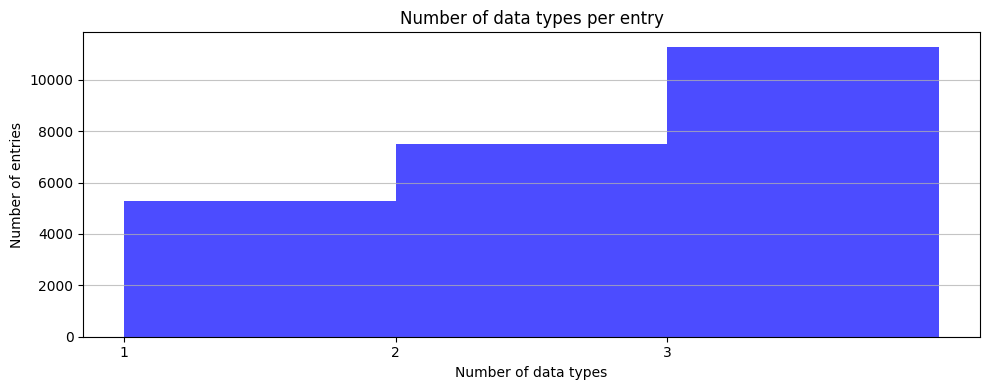

Number of entries with 0 data types: 0 (0.00%)
Number of entries with 1 data type: 5296 (21.98%)
Number of entries with 2 data types: 7513 (31.18%)
Number of entries with 3 data types: 11287 (46.84%)


In [23]:
plot_histogram_of_counts(metadata_int['dtype_n'], title='Number of data types per entry', xlabel='Number of data types', ylabel='Number of entries', zero_start=False, bins_step=1)
print(f"Number of entries with 0 data types: {metadata_int[metadata_int['dtype_n'] == 0].shape[0]} ({metadata_int[metadata_int['dtype_n'] == 0].shape[0] / metadata_int.shape[0] * 100:.2f}%)")
print(f"Number of entries with 1 data type: {metadata_int[metadata_int['dtype_n'] == 1].shape[0]} ({metadata_int[metadata_int['dtype_n'] == 1].shape[0] / metadata_int.shape[0] * 100:.2f}%)")
print(f"Number of entries with 2 data types: {metadata_int[metadata_int['dtype_n'] == 2].shape[0]} ({metadata_int[metadata_int['dtype_n'] == 2].shape[0] / metadata_int.shape[0] * 100:.2f}%)")
print(f"Number of entries with 3 data types: {metadata_int[metadata_int['dtype_n'] == 3].shape[0]} ({metadata_int[metadata_int['dtype_n'] == 3].shape[0] / metadata_int.shape[0] * 100:.2f}%)")

### Valid (3 days) Entries Analysis

## 🤢 | Patient-level Analysis

**Description**
- `n_entries`: Number of entries per patient
- `n_valid_3_entries`: Number of valid (3 prior consecutive days of data) entries per patient
- `n_valid_2_entries`: Number of valid (2 prior consecutive days of data) entries per patient
- `n_valid_1_entries`: Number of valid (1 prior consecutive days of data) entries per patient
- `n_panic`: Number of panic events per patient
- `max_severity`: Maximum panic severity experienced by patient
- `min_severity`: Minimum panic severity experienced by patient
- `mean_severity`: Average panic severity experienced by patient
- `n_dailylog`: Number of daily log entries per patient
- `n_lifelog`: Number of life log entries per patient
- `n_questionnaire`: Number of questionnaire entries per patient
- `sum_dtype`: Number of data (by group) per patient
- `mean_dtype`: Average number of data types per entry per patient

In [24]:
scraped_data_ids = scraped_data['ID'].unique()
data_pre_ids = data_pre['ID'].unique()
print(f"Scraped Data (n): {len(scraped_data_ids)} -> Preprocessed Data (n): {len(data_pre_ids)}")
print(f"{len(scraped_data_ids) - len(data_pre_ids)} patient data were discarded during preprocessing due to entries having only demographic data")

Scraped Data (n): 429 -> Preprocessed Data (n): 274
155 patient data were discarded during preprocessing due to entries having only demographic data


In [25]:
agg_matrix = [
	('n_entries', 'entry_id', 'count'),
	('n_valid_3_entries', 'valid_entry_3', 'sum'),
	('n_valid_2_entries', 'valid_entry_2', 'sum'),
	('n_valid_1_entries', 'valid_entry_1', 'sum'),
	('n_panic', 'panic_label', 'sum'),
    ('max_severity', 'severity', 'max'),
	('min_severity', 'severity', 'min'),
	('mean_severity', 'severity', 'mean'),
	('n_dailylog', 'dailylog_data', 'sum'),
	('n_lifelog', 'lifelog_data', 'sum'),
	('n_questionnaire', 'questionnaire_data', 'sum'),
	('sum_dtype', 'dtype_n', 'sum'),
	('mean_dtype', 'dtype_n', 'mean'),
]
patient_analysis_data = create_empty_df()
patient_analysis_data = aggregate_by_column(metadata, 'ID', agg_matrix)

display(patient_analysis_data.head(5))
save_as_csv(patient_analysis_data, OUTPUT_PATH, f"panic_patient_analysis({metadata_filename})")

,ID,n_entries,n_valid_3_entries,n_valid_2_entries,n_valid_1_entries,n_panic,max_severity,min_severity,mean_severity,n_dailylog,n_lifelog,n_questionnaire,sum_dtype,mean_dtype
0,PXPN_10006,29,18,21,25,3,2.0,1.0,1.33,22,29,29,80,2.76
1,PXPN_10007,29,16,20,24,4,2.0,1.0,1.25,20,29,29,78,2.69
2,PXPN_10008,29,18,21,25,3,2.0,1.0,1.67,20,29,29,78,2.69
3,PXPN_10009,29,18,20,23,5,4.0,1.0,2.60,28,28,29,85,2.93
4,PXPN_10010,29,26,27,28,0,NaN,NaN,NaN,23,28,29,80,2.76


DEBUG - (text_utils.py) save_as_csv: Saved panic_patient_analysis(final_result_20250612).csv to C:\Users\cyshi\OneDrive\Documents\GitHub\Panic-Project-CYS\cys\_output


WindowsPath('C:/Users/cyshi/OneDrive/Documents/GitHub/Panic-Project-CYS/cys/_output/panic_patient_analysis(final_result_20250612).csv')

### Patient-level Entries Analysis

In [26]:
patients_greater_than_100_entries = patient_analysis_data[patient_analysis_data['n_entries'] > 100]
print(f"Number of patients with more than 100 entries: {patients_greater_than_100_entries.shape[0]}")
patients_less_than_100_entries = patient_analysis_data[patient_analysis_data['n_entries'] <= 100]
print(f"Number of patients with less than or equal to 100 entries: {patients_less_than_100_entries.shape[0]}")

Number of patients with more than 100 entries: 75
Number of patients with less than or equal to 100 entries: 199


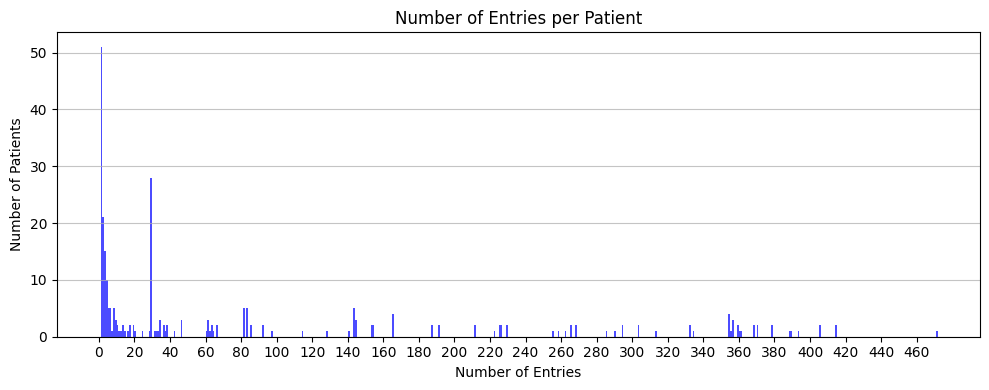

Number of valid patients (1 days): 206 / 274
68 patients do not have valid entries (i.e., no data for at least 1 days before panic event)


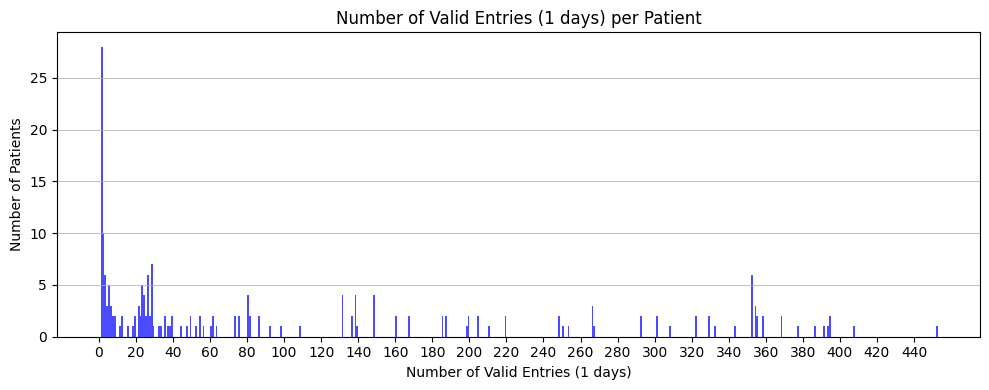

Number of valid patients (2 days): 173 / 274
101 patients do not have valid entries (i.e., no data for at least 2 days before panic event)


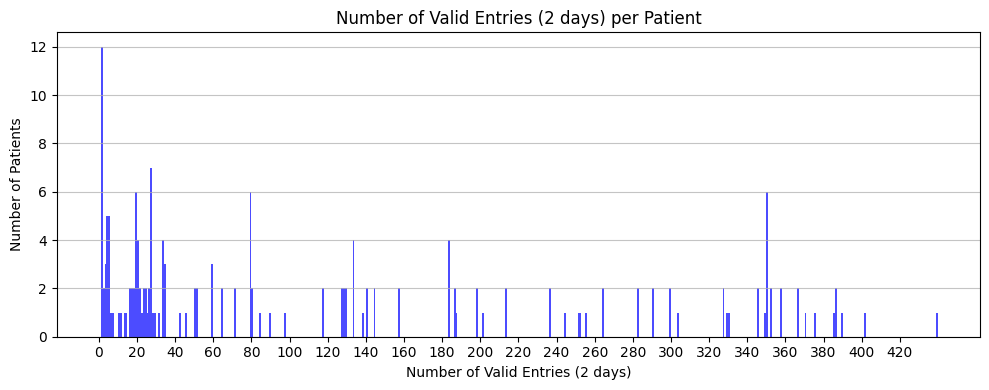

Number of valid patients (3 days): 161 / 274
113 patients do not have valid entries (i.e., no data for at least 3 days before panic event)


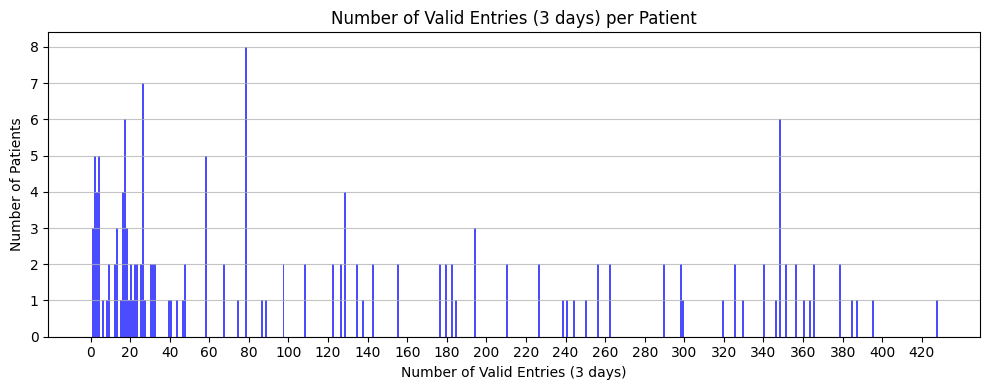

In [27]:
plot_histogram_of_counts(patient_analysis_data['n_entries'], title='Number of Entries per Patient',
                         xlabel='Number of Entries', ylabel='Number of Patients', bins_step=20, exclude_zero=True)
valid_patients = patient_analysis_data[patient_analysis_data['n_valid_1_entries'] > 0]
n_valid_patients_1 = valid_patients.shape[0]
print(f"Number of valid patients (1 days): {valid_patients.shape[0]} / {len(data_pre_ids)}")
print(f"{len(data_pre_ids) - valid_patients.shape[0]} patients do not have valid entries (i.e., no data for at least 1 days before panic event)")
plot_histogram_of_counts(patient_analysis_data['n_valid_1_entries'], title='Number of Valid Entries (1 days) per Patient',
                         xlabel='Number of Valid Entries (1 days)', ylabel='Number of Patients', bins_step=20, exclude_zero=True)
valid_patients = patient_analysis_data[patient_analysis_data['n_valid_2_entries'] > 0]
n_valid_patients_2 = valid_patients.shape[0]
print(f"Number of valid patients (2 days): {valid_patients.shape[0]} / {len(data_pre_ids)}")
print(f"{len(data_pre_ids) - valid_patients.shape[0]} patients do not have valid entries (i.e., no data for at least 2 days before panic event)")
plot_histogram_of_counts(patient_analysis_data['n_valid_2_entries'], title='Number of Valid Entries (2 days) per Patient',
                         xlabel='Number of Valid Entries (2 days)', ylabel='Number of Patients', bins_step=20, exclude_zero=True)
valid_patients = patient_analysis_data[patient_analysis_data['n_valid_3_entries'] > 0]
n_valid_patients_3 = valid_patients.shape[0]
print(f"Number of valid patients (3 days): {valid_patients.shape[0]} / {len(data_pre_ids)}")
print(f"{len(data_pre_ids) - valid_patients.shape[0]} patients do not have valid entries (i.e., no data for at least 3 days before panic event)")
plot_histogram_of_counts(patient_analysis_data['n_valid_3_entries'], title='Number of Valid Entries (3 days) per Patient',
                         xlabel='Number of Valid Entries (3 days)', ylabel='Number of Patients', bins_step=20, exclude_zero=True)
del valid_patients

### Patient-level Panic Analysis

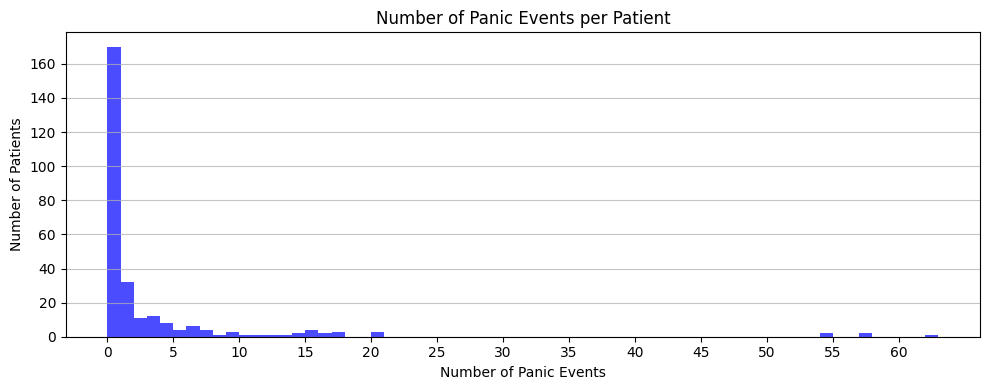

Number of patients with zero panic events: 170 / 274


In [28]:
plot_histogram_of_counts(patient_analysis_data['n_panic'], title='Number of Panic Events per Patient', xlabel='Number of Panic Events', ylabel='Number of Patients', bins_step=5)
print(f"Number of patients with zero panic events: {patient_analysis_data[patient_analysis_data['n_panic'] == 0].shape[0]} / {len(data_pre_ids)}")

In [29]:
valid_panic_events_patients = patient_analysis_data[(patient_analysis_data['n_panic'] > 0) & (patient_analysis_data['n_valid_3_entries'] > 0)]
print(f"Number of patients with valid panic events (3 days): {valid_panic_events_patients.shape[0]} / {n_valid_patients_3}")
valid_panic_events_patients = patient_analysis_data[(patient_analysis_data['n_panic'] > 0) & (patient_analysis_data['n_valid_2_entries'] > 0)]
print(f"Number of patients with valid panic events (2 days): {valid_panic_events_patients.shape[0]} / {n_valid_patients_2}")
valid_panic_events_patients = patient_analysis_data[(patient_analysis_data['n_panic'] > 0) & (patient_analysis_data['n_valid_1_entries'] > 0)]
print(f"Number of patients with valid panic events (1 days): {valid_panic_events_patients.shape[0]} / {n_valid_patients_1}")
del valid_panic_events_patients

Number of patients with valid panic events (3 days): 81 / 161
Number of patients with valid panic events (2 days): 86 / 173
Number of patients with valid panic events (1 days): 93 / 206


### Patient-level Data Group Analysis

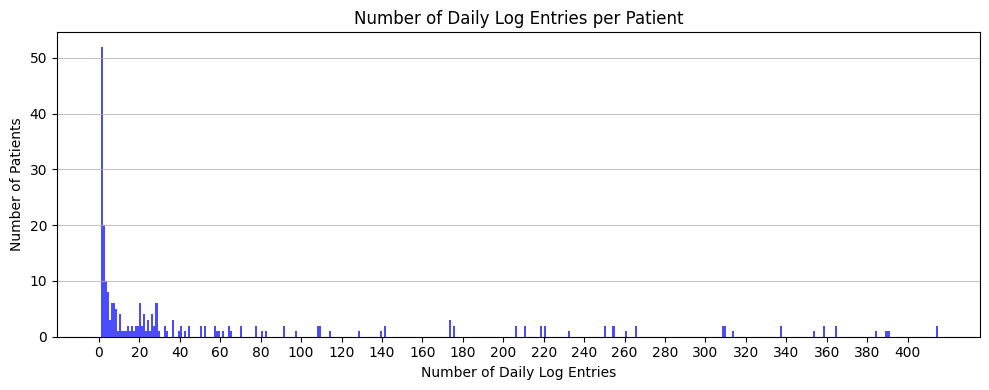

Number of patients with no daily log entries: 36 / 274


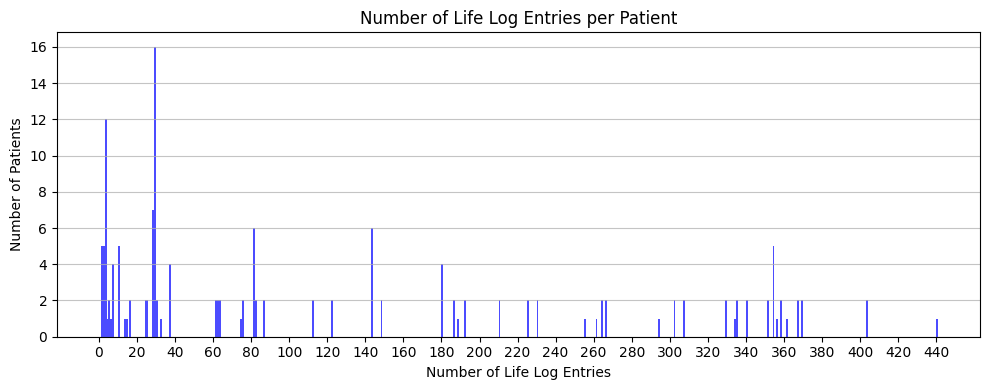

Number of patients with no life log entries: 119 / 274


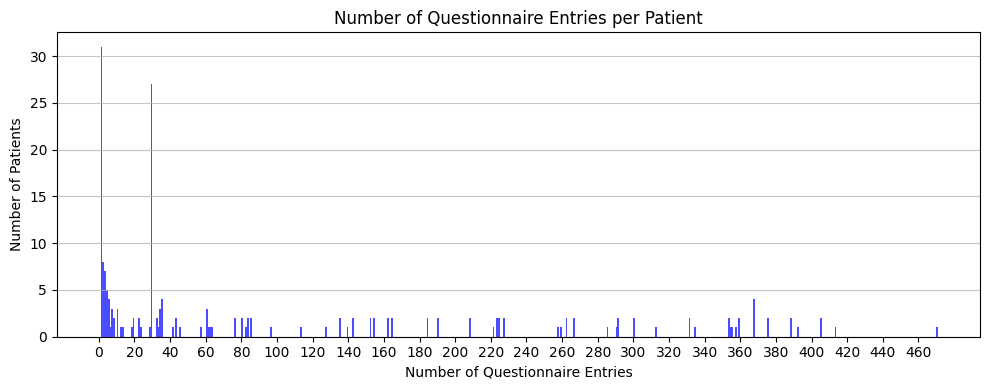

Number of patients with no questionnaire entries: 79 / 274


In [30]:
plot_histogram_of_counts(patient_analysis_data['n_dailylog'], title='Number of Daily Log Entries per Patient',
						 xlabel='Number of Daily Log Entries', ylabel='Number of Patients', bins_step=20, exclude_zero=True)
print(f"Number of patients with no daily log entries: {patient_analysis_data[patient_analysis_data['n_dailylog'] == 0].shape[0]} / {len(data_pre_ids)}")
plot_histogram_of_counts(patient_analysis_data['n_lifelog'], title='Number of Life Log Entries per Patient',
						 xlabel='Number of Life Log Entries', ylabel='Number of Patients', bins_step=20, exclude_zero=True)
print(f"Number of patients with no life log entries: {patient_analysis_data[patient_analysis_data['n_lifelog'] == 0].shape[0]} / {len(data_pre_ids)}")
plot_histogram_of_counts(patient_analysis_data['n_questionnaire'], title='Number of Questionnaire Entries per Patient',
						 xlabel='Number of Questionnaire Entries', ylabel='Number of Patients', bins_step=20, exclude_zero=True)
print(f"Number of patients with no questionnaire entries: {patient_analysis_data[patient_analysis_data['n_questionnaire'] == 0].shape[0]} / {len(data_pre_ids)}")

In [31]:
valid_panic_events_3_ids = valid_panic_events_3['ID'].unique()
print(f"Number of unique IDs with valid panic events (3 days): {len(valid_panic_events_3_ids)}")
severity_1 = valid_panic_events_3[valid_panic_events_3['severity'] == 1]
severity_2 = valid_panic_events_3[valid_panic_events_3['severity'] == 2]
severity_3 = valid_panic_events_3[valid_panic_events_3['severity'] == 3]
severity_4 = valid_panic_events_3[valid_panic_events_3['severity'] == 4]
severity_5 = valid_panic_events_3[valid_panic_events_3['severity'] == 5]
severity_1_ids = severity_1['ID'].unique()
severity_2_ids = severity_2['ID'].unique()
severity_3_ids = severity_3['ID'].unique()
severity_4_ids = severity_4['ID'].unique()
severity_5_ids = severity_5['ID'].unique()
print(f"Number of unique IDs with valid panic events (3 days) and severity 1: {len(severity_1_ids)}")
print(f"Number of unique IDs with valid panic events (3 days) and severity 2: {len(severity_2_ids)}")
print(f"Number of unique IDs with valid panic events (3 days) and severity 3: {len(severity_3_ids)}")
print(f"Number of unique IDs with valid panic events (3 days) and severity 4: {len(severity_4_ids)}")
print(f"Number of unique IDs with valid panic events (3 days) and severity 5: {len(severity_5_ids)}")

Number of unique IDs with valid panic events (3 days): 64
Number of unique IDs with valid panic events (3 days) and severity 1: 27
Number of unique IDs with valid panic events (3 days) and severity 2: 25
Number of unique IDs with valid panic events (3 days) and severity 3: 29
Number of unique IDs with valid panic events (3 days) and severity 4: 22
Number of unique IDs with valid panic events (3 days) and severity 5: 8


In [32]:
valid_panic_events_2_ids = valid_panic_events_2['ID'].unique()
valid_panic_events_1_ids = valid_panic_events_1['ID'].unique()
print(f"Number of unique IDs with valid panic events (2 days): {len(valid_panic_events_2_ids)}")
print(f"Number of unique IDs with valid panic events (1 days): {len(valid_panic_events_1_ids)}")

Number of unique IDs with valid panic events (2 days): 68
Number of unique IDs with valid panic events (1 days): 78
